In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# reading in data and printing first 1000 chars
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
print("length of dataset in characters: ", len(text))
print(text[:1000])

length of dataset in characters:  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hung

In [9]:
# getting all unique chars and determining possible output classes- vocab_size

chars = list(sorted(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [10]:
# creating an encoding and decoding to convert string to int and vice versa

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda i: ''.join([itos[chi] for chi in i])

print(encode("hii there"))
print(decode(encode("hii there")))


[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [11]:
import torch


data = torch.tensor(encode(text), dtype=torch.long) # using long type for class ints
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # block_size is like context window

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,)) # list of len(batch_size) of ints in data
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y



xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')    

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----


In [13]:
# starting with a bigram without training.

import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class bigram(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.n_embd_table = nn.Embedding(vocab_size, n_embd)
        
    def forward(self, IX, targets=None): # ix is (B,T) with int representing row to be queried for embedding.
        logits = self.n_embd_table(IX) # (B, T, C)
        
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) 
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_new_token):
        for _ in range(max_new_token):
        
            logits, loss = self(idx)
            logits = logits[:,-1,:] # getting the last prediction. ideally this should be context length i think. 
            probs = F.softmax(logits, -1)
            pred = torch.multinomial(probs,1)
            idx = torch.cat((idx, pred),dim=1)
        
        return idx
            

model = bigram(vocab_size, vocab_size)
logits, loss = model(xb, yb)    
print(loss) # ln(1.0/65)=4.17 because vocab_size is 65. 65 possible outputs.
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_token=100)[0].tolist()))


tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [52]:
# starting with a bigram without training.

import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class bigram(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.n_embd_table = nn.Embedding(vocab_size, n_embd)
        
    def forward(self, IX, targets=None): # ix is (B,T) with int representing row to be queried for embedding.
        logits = self.n_embd_table(IX) # (B, T, C)
        
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) 
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_new_token):
        for _ in range(max_new_token):
        
            logits, loss = self(idx)
            logits = logits[:,-1,:] # getting the last prediction. ideally this should be context length i think. 
            probs = F.softmax(logits, -1)
            pred = torch.multinomial(probs,1)
            idx = torch.cat((idx, pred),dim=1)
        
        return idx
            
model = bigram(vocab_size, vocab_size)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)


training_step = 10000
batch_size = 32

for step in range(training_step):
    
    xb, yb = get_batch('train') # global batch_size being used here
    # print(f"input shape is {xb.shape} and target shape is {yb.shape}")
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())    
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_token=1000)[0].tolist()))


2.394822597503662

Ke sonidin y y a!
Caril.n y, denjxhece w illd CHAL, mer thoun s's:Conchuntilalllevise sthat dy hangilyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z,
Thitertho s?
NDan'spererfo cist ripl chys er orlese;
Yo jehof h hecere ek? wferommot mowo soaf yoit, ince his, t, f at. fal whetrimy bupof tor atha Bu!
JOutho f cimimave.
NEDUSt cir selle p wie wede
Ro n apenor f'Y tover witys an sh d w t e w!
CEOntiretoaveE IINpe, theck. cung.
ORIsthies hacin benqurd bll, d a r w wistatsowor ath
Fivet bloll ang a-I theeancu,
LINCI'T:
Sarry t 

In [ ]:
# consider the following toy example to calculate weighted mean of all weights till each time step t including the weight of t:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# calculating the mean of all weights from left to right till chat t including the weight of t itself:

xbow= torch.zeros_like(x)
for each_exm in range(x.shape[0]):
    for char_index in range(x.shape[1]):
        xprev = x[each_exm, :char_index+1] # (t, C) here batch gets eliminated since its 1d
        xbow[each_exm,char_index]=torch.mean(xprev, 0)  

xbow.shape   

torch.Size([4, 8, 2])

In [43]:
#  doing the above in matrix multiplication. we

# tril = torch.tril(torch.ones(T, T))
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(f"{wei.shape}, {x.shape}")
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-6)

torch.Size([8, 8]), torch.Size([4, 8, 2])


True

In [ ]:
# manually going through a attention block

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, blocksize/context length, n_embd
x = torch.randn(B,T,C)

head_size=4
query = nn.Linear(C,head_size, bias=False) # (n_embd, attention block size)
key = nn.Linear(C,head_size, bias=False)   # (n_embd, attention block size)
value = nn.Linear(C,head_size, bias=False) # (n_embd, attention block size)
q = query(x) # (B,T/blocksize, attention_block_size)
k = key(x) # (B,T/blocksize, attention_block_size)
wei = q @ k.transpose(-2,-1) * head_size**-0.5 # (B, T, attention_block_size) @ (B, attention_block_size, T) ===> (B, T , T) # we multiply by 1/sqrt(head_size) to ensure variance is 1 instead of being very high

tril = torch.tril(torch.ones(T,T)) 
# wei = torch.zeros(T,T)
wei = wei.masked_fill(tril==0,float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ value(x) # (B, blocksize/context length/T, attention block size)
# out = wei @ x
out.shape

torch.Size([4, 8, 4])

In [69]:
# adding attention heads to model and training

import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# vocab_size = 65 #len of all unique chars
block_size = 8
training_step = 10000
batch_size = 32
n_embd = 16
head_size=16

# creating a attention block
class AttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd,head_size, bias=False) # c = n_embd
        self.key = nn.Linear(n_embd,head_size, bias=False) # c = n_embd
        self.value = nn.Linear(n_embd,head_size, bias=False) # c = n_embd
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
        
    def forward(self,x):
        q = self.query(x) # (B,T/blocksize, attention_block_size)
        k = self.key(x)   # (B,T/blocksize, attention_block_size)
        wei = q @ k.transpose(-2,-1) * head_size**-0.5 # (B, T, attention_block_size) @ (B, attention_block_size, T) ===> (B, T , T) # we multiply by 1/sqrt(head_size) to ensure variance is 1 instead of being very high
        wei = wei.masked_fill(self.tril==0,float('-inf')) # (B,T,T)
        wei = F.softmax(wei, dim=-1)
        
        v = self.value(x)
        out = wei @ v # (B,T,T) @ (B,T,head_size) ==> (B,T,head_size)
        return out


class bigram(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.n_embd_table = nn.Embedding(vocab_size, n_embd)
        self.position_embed_table = nn.Embedding(block_size, n_embd)
        self.sa_head = AttentionHead(n_embd ,head_size)
        self.lm = nn.Linear(n_embd,vocab_size)
        
    def forward(self, IX, targets=None): # ix is (B,T) with int representing row to be queried for embedding.
        tok_embd = self.n_embd_table(IX) # (B, T, n_embd)
        pos_embd = self.position_embed_table(torch.arange(tok_embd.shape[1])) # (T,n_embd)
        x = tok_embd + pos_embd # B,T,n_embd
        x = self.sa_head(x)
        logits = self.lm(x) # (B, T, vocab_size)
        
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) 
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_new_token):
        for _ in range(max_new_token):
            idx_block_size = idx[:, -block_size:]
            logits, loss = self(idx_block_size)
            logits = logits[:,-1,:] # getting the last prediction. ideally this should be context length i think. 
            probs = F.softmax(logits, -1)
            pred = torch.multinomial(probs,1)
            idx = torch.cat((idx, pred),dim=1)
        
        return idx
            

model = bigram(vocab_size, n_embd)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
for step in range(training_step):
    
    xb, yb = get_batch('train') # global batch_size being used here
    # print(f"input shape is {xb.shape} and target shape is {yb.shape}")
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())    
print(decode(model.generate(idx = torch.zeros((1, block_size), dtype=torch.long), max_new_token=1000)[0].tolist()))


2.4983792304992676








IOLE:
P:
Ane no aty undout the thang-'d! teng tamy menas th I hantree es I sto atherd'tt mas ci hileound ner'st terey yeawrstief:
Fre yoomero!

Hould brs knd
ou nd go enre.! Gof toele thinove tor wen a fmo so,
On wes fromsse.

hire,
LUELIODWh ther-hy celde tyo ume heailmen, arine ho nt orde esha, akirot me ther'd thesse,
SThe cher th'd od, tpas de or hat if dn fof coun,, ios hll ownisa, a mutck out ud tit dinte rourit fole hy por;
Tho;
Bugn, unst ghnde
mii thath murrsfo wir.

Unersoianto my ds joilal ver thomes lfoud lline.
L: I munkn nto be medne se gspe, llate mono f: tho: ona houd on pirens ot ithomar an tiughe Hacign hat inkn,
NIpl hyomeret coum hef hyoto fe waksu wagr had tit:
He.

NES:
S t the penses woro'mal sove wit MI it hilutung hro kerond whbeanvedeantfl thild thine, thake rt ot st wnss thout thin art, dearigthrt mof the thicarsy her? helle. Cet owthifou nsesthilke them:
I he su dathim?

Bour ech, us houby.
Posee, ce sel ke,
ICS:
R:
QUDau rf cho Rf









IOLE:
P:
Ane no aty undout the thang-'d! teng tamy menas th I hantree es I sto atherd'tt mas ci hileound ner'st terey yeawrstief:
Fre yoomero!

Hould brs knd
ou nd go enre.! Gof toele thinove tor wen a fmo so,
On wes fromsse.

hire,
LUELIODWh ther-hy celde tyo ume heailmen, arine ho nt orde esha, akirot me ther'd thesse,
SThe cher th'd od, tpas de or hat if dn fof coun,, ios hll ownisa, a mutck out ud tit dinte rourit fole hy por;
Tho;
Bugn, unst ghnde
mii thath murrsfo wir.

Unersoianto my ds joilal ver thomes lfoud lline.
L: I munkn nto be medne se gspe, llate mono f: tho: ona houd on pirens ot ithomar an tiughe Hacign hat inkn,
NIpl hyomeret coum hef hyoto fe waksu wagr had tit:
He.

NES:
S t the penses woro'mal sove wit MI it hilutung hro kerond whbeanvedeantfl thild thine, thake rt ot st wnss thout thin art, dearigthrt mof the thicarsy her? helle. Cet owthifou nsesthilke them:
I he su dathim?

Bour ech, us houby.
Posee, ce sel ke,
ICS:
R:
QUDau rf cho Rf fourd Colourorstho

step 0: train loss 4.4101, val loss 4.4007
step 100: train loss 3.1094, val loss 3.1229
step 200: train loss 2.7770, val loss 2.7929
step 300: train loss 2.6374, val loss 2.6378
step 400: train loss 2.5691, val loss 2.5764
step 500: train loss 2.5251, val loss 2.5185
step 600: train loss 2.4895, val loss 2.4840
step 700: train loss 2.4560, val loss 2.4534
step 800: train loss 2.4356, val loss 2.4269
step 900: train loss 2.4022, val loss 2.4038
step 1000: train loss 2.3815, val loss 2.3740
step 1100: train loss 2.3435, val loss 2.3523
step 1200: train loss 2.3258, val loss 2.3319
step 1300: train loss 2.3114, val loss 2.3178
step 1400: train loss 2.2948, val loss 2.3042
step 1500: train loss 2.2893, val loss 2.2893
step 1600: train loss 2.2570, val loss 2.2709
step 1700: train loss 2.2491, val loss 2.2613
step 1800: train loss 2.2303, val loss 2.2365
step 1900: train loss 2.2219, val loss 2.2242
step 2000: train loss 2.2043, val loss 2.2135
step 2100: train loss 2.1910, val loss 2.2072


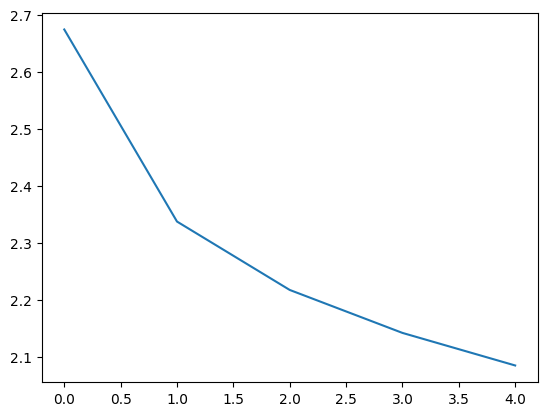

In [ ]:
# working with multi-head attention and adding layernorm + skip connection

# adding attention heads to model and training

import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# vocab_size = 65 #len of all unique chars
block_size = 32
training_step = 5000
batch_size = 16
n_embd = 64
# head_size=16
num_heads_in_att = 4
num_atten_blocks = 4
eval_interval = 100
dropout = 0.2

# creating a attention block
class AttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd,head_size, bias=False) # c = n_embd
        self.key = nn.Linear(n_embd,head_size, bias=False) # c = n_embd
        self.value = nn.Linear(n_embd,head_size, bias=False) # c = n_embd
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self,x):
        q = self.query(x) # (B,T/blocksize, attention_block_size)
        k = self.key(x)   # (B,T/blocksize, attention_block_size)
        wei = q @ k.transpose(-2,-1) * head_size**-0.5 # (B, T, attention_block_size) @ (B, attention_block_size, T) ===> (B, T , T) # we multiply by 1/sqrt(head_size) to ensure variance is 1 instead of being very high
        wei = wei.masked_fill(self.tril==0,float('-inf')) # (B,T,T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v # (B,T,T) @ (B,T,head_size) ==> (B,T,head_size)
        return out

class MultiheadAtention(nn.Module):
    def __init__(self, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(n_embd,head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    def __init__(self, n_embd, num_heads):
        super().__init__()
        self.sa_head = MultiheadAtention(num_heads, n_embd ,n_embd//num_heads)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self,x):
        x = x + self.sa_head(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class bigram(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.n_embd_table = nn.Embedding(vocab_size, n_embd)
        self.position_embed_table = nn.Embedding(block_size, n_embd)
        self.attenblocks = nn.Sequential(*[Block(n_embd, num_heads_in_att) for _ in range(num_atten_blocks)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm = nn.Linear(n_embd,vocab_size)
        
    def forward(self, IX, targets=None): # ix is (B,T) with int representing row to be queried for embedding.
        tok_embd = self.n_embd_table(IX) # (B, T, n_embd)
        pos_embd = self.position_embed_table(torch.arange(tok_embd.shape[1])) # (T,n_embd)
        x = tok_embd + pos_embd # B,T,n_embd
        x = self.attenblocks(x)
        x = self.ln_f(x)
        logits = self.lm(x) # (B, T, vocab_size)
        
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T) 
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
        
        return logits, loss
    
    def generate(self, idx, max_new_token):
        for _ in range(max_new_token):
            idx_block_size = idx[:, -block_size:]
            logits, loss = self(idx_block_size)
            logits = logits[:,-1,:] # getting the last prediction. ideally this should be context length i think. 
            probs = F.softmax(logits, -1)
            pred = torch.multinomial(probs,1)
            idx = torch.cat((idx, pred),dim=1)
        
        return idx
            
@torch.no_grad()
def estimate_loss():
    eval_iters = 200
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

model = bigram(vocab_size, n_embd)
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)

lossi=[]
for step in range(training_step):
    
    # every once in a while evaluate the loss on train and val sets
    if step % eval_interval == 0 or step == training_step - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
    
    xb, yb = get_batch('train') # global batch_size being used here
    # print(f"input shape is {xb.shape} and target shape is {yb.shape}")
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

# print(loss.item())     
print(decode(model.generate(idx = torch.zeros((1, block_size), dtype=torch.long), max_new_token=1000)[0].tolist()))
plt.plot(torch.tensor(lossi).view(-1,100).mean(1));

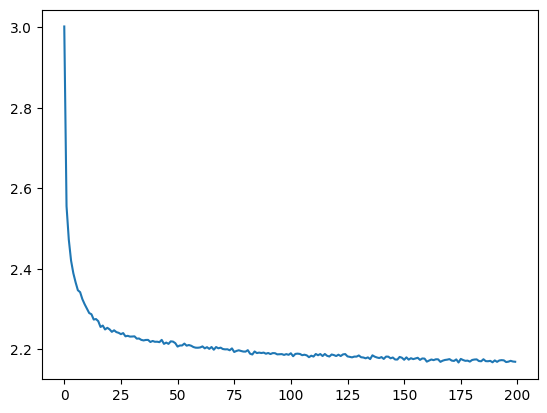

In [80]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));